In [3]:
protein = "MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG"
from disassembly.simulate_proteolysis import (
    simulate_proteolysis,
    enzyme_set,
    enzyme,
)
from disassembly.util import amino_acids

n_generate = 500

k_enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
    ],
    [1],
    [1],
)

kr_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
    ],
    [1],
    [1],
)

viat_enzymes = enzyme_set(
    [
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1],
    [1],
)

krviat_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1],
    [1, 1],
)

random_enzymes = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [4]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["kr", "viat", "random"]


for enz, name in zip(
    [kr_enzymes, viat_enzymes, random_enzymes], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}", end="", flush=True)
        generated_peptidome = simulate_proteolysis(
            protein,
            n_start=1,
            n_generate=n_generate,
            endo_or_exo_probability=[0.9,0.1],
            enzymes=enz,
            graph=False,
            verbose=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

kr
1

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


9viat
9random
9

In [5]:
from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare

comparisons = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        err = KL(p, q) + KL(q, p)
        comparisons[name_comp_1][name_comp_2] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


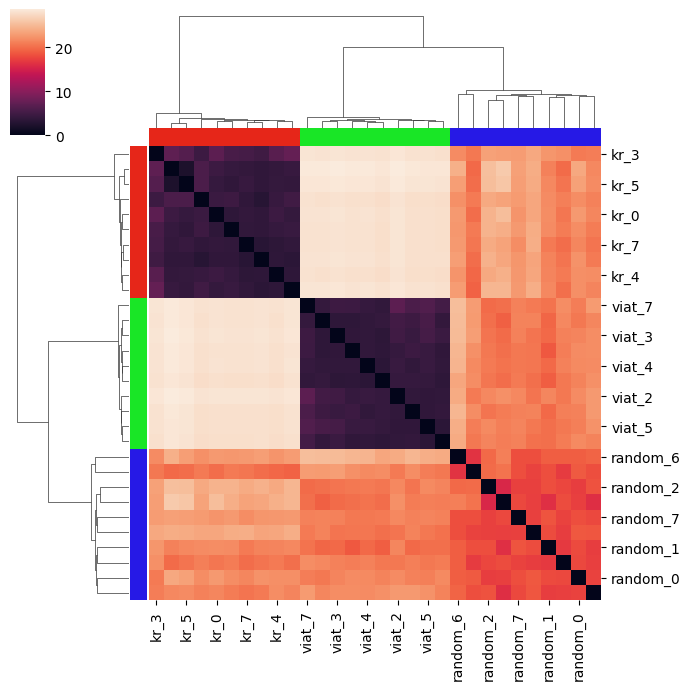

In [6]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [7]:
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme


# Say we want to estimate parameters for K enzyme.
enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [0, 0, 1],  # activities
    [0,0, 1],  # abundances
)


true_dict, sequence_graph = simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=n_generate,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
    graph=True,
)

 99 / 500 (117)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 499 / 500 (728)
134 unique peptides. 501 total


Iteration: 0
	V: 17.53 | 21.36
V better!
	V: 16.03 | 17.53
V better!
	V: 14.50 | 16.03
V better!
	V: 17.52 | 14.50
	I: 13.07 | 14.50
I better!
	I: 11.47 | 13.07
I better!
	I: 11.54 | 11.47
	L: 16.06 | 11.47
	E: 17.31 | 11.47
	Q: 12.00 | 11.47
	D: 10.99 | 11.47
D better!
	D: 12.85 | 10.99
	N: 12.25 | 10.99
	H: 12.70 | 10.99
	W: 12.01 | 10.99
	F: 13.55 | 10.99
	Y: 15.59 | 10.99
	R: 18.80 | 10.99
	K: 17.83 | 10.99
	S: 13.60 | 10.99
	T: 11.51 | 10.99
	M: 11.72 | 10.99
	A: 9.83 | 10.99
A better!
	A: 10.98 | 9.83
	G: 14.51 | 9.83
	P: 10.18 | 9.83
	C: 9.64 | 9.83
C better!
	C: 9.82 | 9.64
 exo: 9.00 | 9.00 (0.20)
 exo: 8.87 | 8.87 (0.15)
 exo: 10.33 | 8.87 (0.15)
 exo: 10.30 | 8.87 (0.15)
 exo: 10.83 | 8.87 (0.15)
 exo: 10.27 | 8.87 (0.15)
 exo: 10.95 | 8.87 (0.15)
 exo: 9.95 | 8.87 (0.15)
 exo: 9.28 | 8.87 (0.15)
 exo: 9.22 | 8.87 (0.15)
 exo: 10.26 | 8.87 (0.15)
 exo: 11.75 | 8.87 (0.15)
 exo: 9.86 | 8.87 (0.15)
 exo: 9.26 | 8.87 (0.15)
 exo: 9.52 | 8.87 (0.15)
 exo: 9.70 | 8.87 (0.15)
 exo

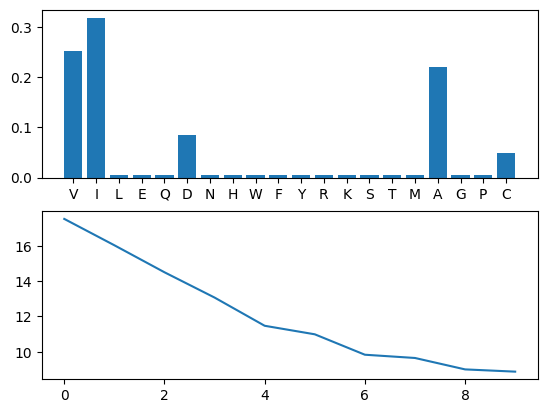

In [8]:
from disassembly.estimate_parameters import ParameterEstimator

pe = ParameterEstimator()

parameters = pe.estimate(
    protein, true_dict, n_generate=n_generate, n_iterations_endo=1, n_iterations_exo=20
)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].bar(parameters["endo"].keys(), parameters["endo"].values())
axs[1].plot(pe.best_losses)
print(parameters["exo"])

 199 / 200 | 1.13, kl: 0.28, reg: 0.85  | nz: 2323 | 

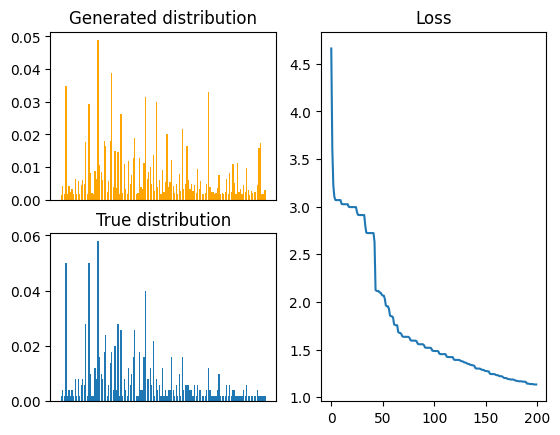

In [9]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=0.1, n_iterations=200, lam1=0.01, lam2=0.01)

G = wegd.run(true_dict, verbose=True, parameters=parameters)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [["generated", "loss"], ["true", "loss"]], width_ratios=[2, 2]
)


axs["true"].bar(
    true_dict.keys(), [v / sum(true_dict.values()) for v in true_dict.values()]
)
axs["generated"].bar(
    generated[len(generated.keys()) - 1].keys(),
    generated[len(generated.keys()) - 1].values(),
    color="orange",
)
axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

0.8080491696708232

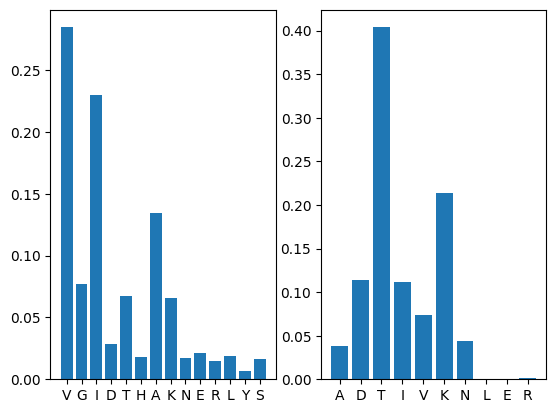

In [10]:
from disassembly.cut_site import get_p1

p1_endo, p1_exo,  n_endo, n_exo = get_p1(G, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

0.9787967242357901

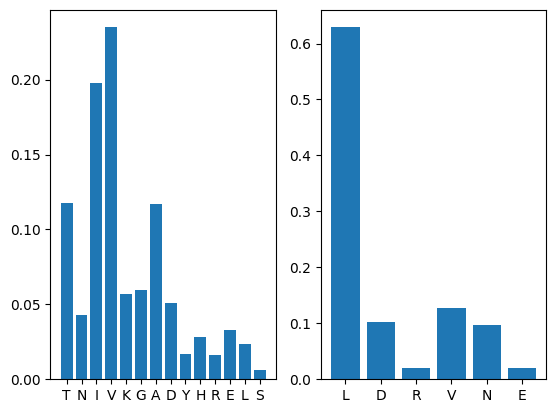

In [11]:

p1_endo, p1_exo,  n_endo, n_exo = get_p1(sequence_graph, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

In [12]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

print("Real")
real_disassembly_indexes = get_disassembly_indexes_mc(sequence_graph, N_particles=10000)
print(get_disassembly(true_dict, real_disassembly_indexes))
print("Estimated")
mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(true_dict, mc_di)

Real

 Averaged DI: 2.19
15.487435945604558
Estimated

 Averaged DI: 3.12


49.0064050437496

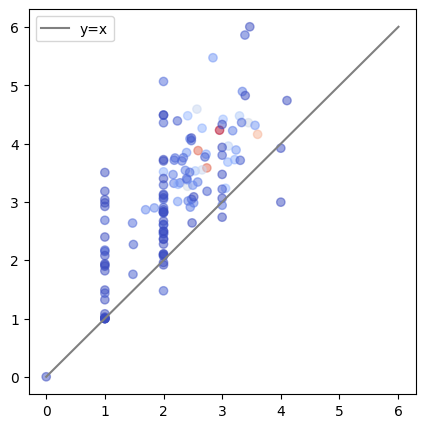

In [13]:
from disassembly.util import plot_di_correlation

plot_di_correlation(true_dict, real_disassembly_indexes, mc_di)

# Check if simulated proteolysis has a reasonable distance


In [14]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "H4"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

In [15]:
pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})
df_simulated.head()

,Peptide,kr_0,kr_1,kr_2,kr_3,kr_4,kr_5,kr_6,kr_7,kr_8,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
0,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKR...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,ISGLIYEETRGVLKVFLENVIRDAVTYTEHAKR,5.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RISGLIYEETRGVLKVFLENVIRDAVTYTEHAKR,3.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GKGGKGLGKGGAKRHRKVLRDNIQGITKPAI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DNIQGITKPAIRRLARRGGVKRISGLIYEETRGVL,2.0,1.0,2.0,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
merged = df.reset_index().merge(df_simulated, left_on="Peptide", right_on="Peptide")
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns

In [17]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()

    protein_dict = {}

    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG': {'RKTVTAMDVVYALKR': 0,
   'KTVTAMDVVYALKR': 0,
   'ENVIRDAVTYTEHAKRKTVTAM': 0,
   'KTVTAMDVVYALK': 0,
   'VIRDAVTYTEHAKRKTVTAM': 0,
   'VFLENVIRDAVTYTEHAKR': 0,
   'VFLENVIRDAVTY': 0,
   'TVTAMDVVYALKR': 0,
   'VFLENVIRDAVTYTEHAK': 0,
   'IRDAVTYTEHAKRKTVTAM': 0,
   'DNIQGITKPAIRR': 0,
   'DNIQGITKPAIR': 0,
   'VLRDNIQGITKPAIR': 1,
   'TAMDVVYALKR': 0,
   'RDNIQGITKPAIR': 2,
   'FLENVIRDAVTYT': 0,
   'FLENVIRDAVTYTEHA': 0,
   'VIRDAVTYTEHAK': 0,
   'VLRDNIQGITKPAIRR': 0,
   'VFLENVIRDAVT': 0,
   'ISGLIYEETR': 0,
   'NVIRDAVTYTEHAKRKTVTAM': 0,
   'AMDVVYALKR': 0,
   'ISGLIYEETRGVLK': 0,
   'KVFLENVIRDAVTY': 2,
   'RISGLIYEETR': 0,
   'NVIRDAVTYTEHAK': 0,
   'KVFLENVIRDAVTYTEHAKRKTVTA': 0,
   'TVTAMDVVYALK': 0,
   'VIRDAVTYTEHA': 0,
   'AVTYTEHAKRKTVTAM': 0,
   'MDVVYALKR': 0,
   'KVFLENVIRDAVT': 0,
   'IRDAVTYTEHAK': 0,
   'KVFLENVIRD': 0,
   'DAVTYTEHAK': 0,
   'FLENVIRD

In [18]:
comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

In [20]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 30

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


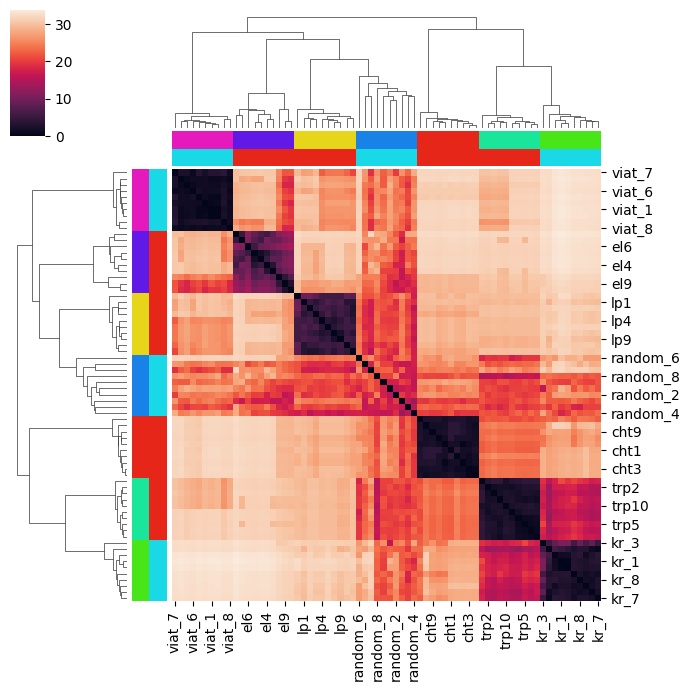

In [21]:
import seaborn as sns

labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
)

In [22]:
wanted_cols = [col for col in merged.columns if (col.startswith("trp") or col.startswith("kr_"))]
kr_trp = merged[wanted_cols]
kr_trp

,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10,kr_0,kr_1,kr_2,kr_3,kr_4,kr_5,kr_6,kr_7,kr_8,kr_9
Peptide,,,,,,,,,,,,,,,,,,,,
RKTVTAMDVVYALKR,2,2,1,1,1,1,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALKR,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRDAVTYTEHAKRKTVTAM,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALK,1,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,2.0
VIRDAVTYTEHAKRKTVTAM,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ITKPAIRRLARRGGVK,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIQGITKPAIRRLARRGGVKRISGL,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIQGITKPAIRR,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


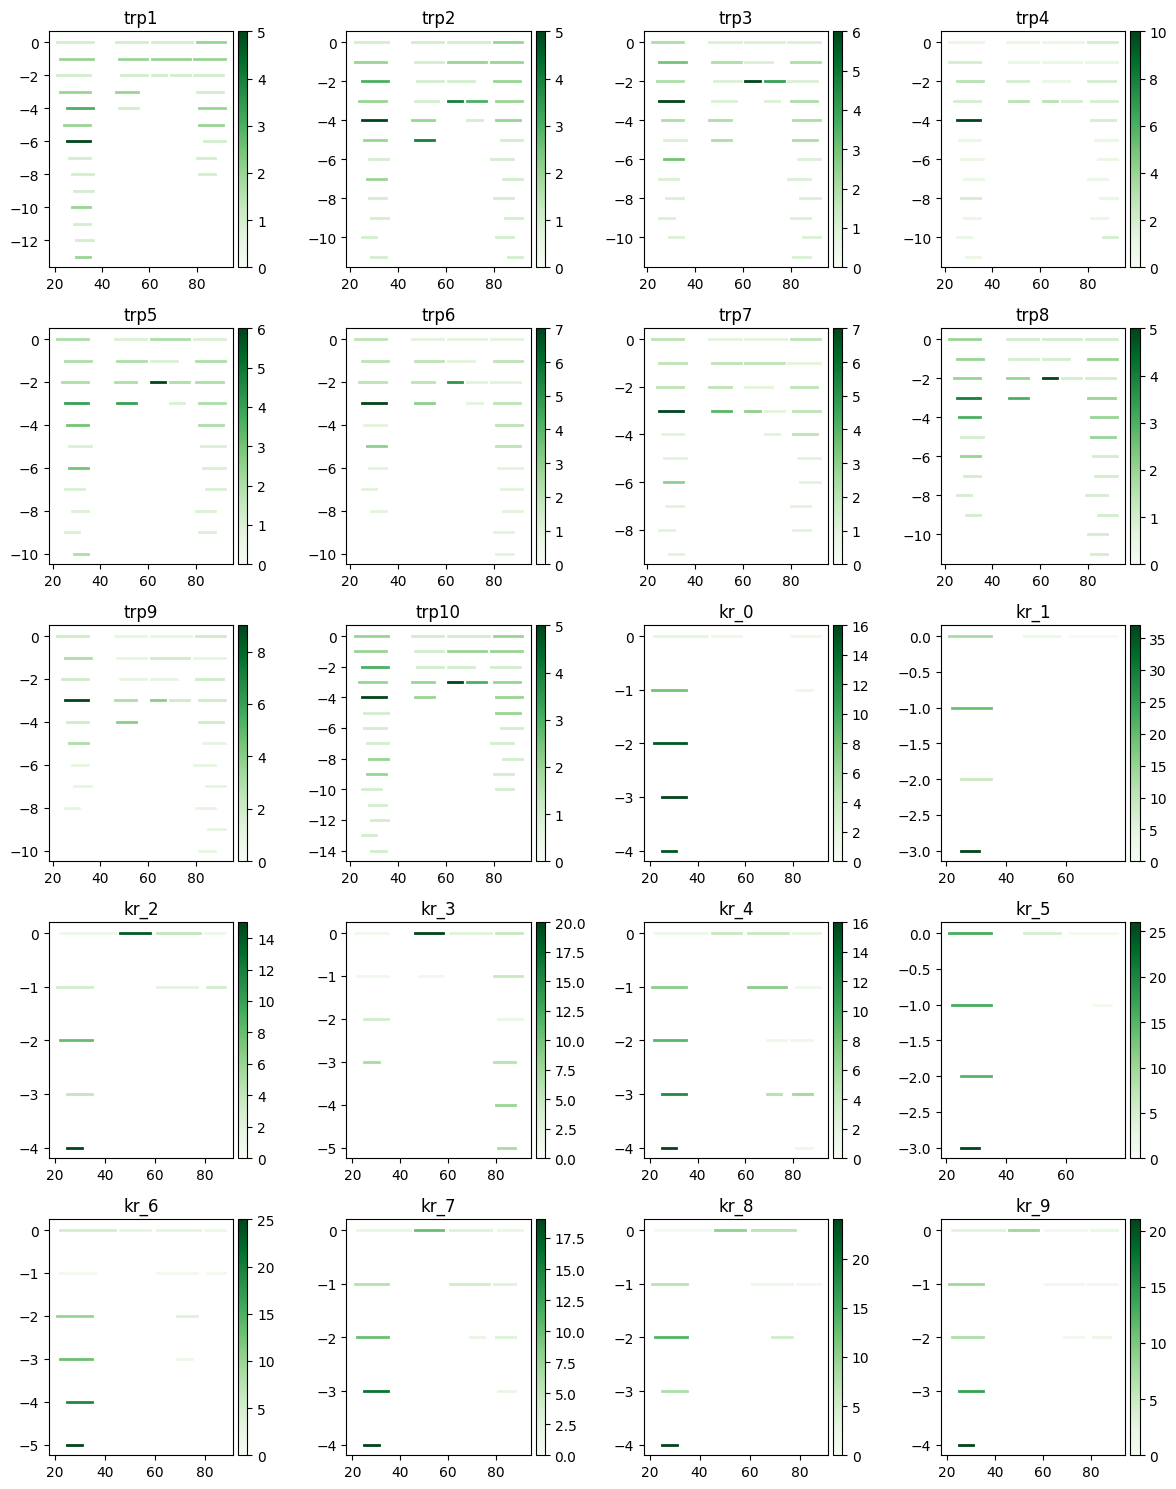

In [23]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(
    5,
    4,
    figsize=(12, 15),
)
samples = kr_trp.columns.tolist()
for col, ax in zip(kr_trp.columns, axs.ravel()):
    d = kr_trp[col]
    i = kr_trp.columns.tolist().index(col)

    ax.set_title(f"{col}")
    d = d.replace(0,np.nan).dropna()

    plot_peptidome(
        protein,
        d,
        ax,
    )
plt.tight_layout()